In [22]:
from math import sqrt
import numpy as np
from numpy import concatenate
from numpy import loadtxt
from matplotlib import pyplot
import pandas
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten
from keras.layers import LSTM
from datetime import datetime
import matplotlib.pyplot as plt

In [23]:
# load the data set
dataset = read_csv('rossman.csv')
dataset['Date']=pandas.to_datetime(dataset['Date'],infer_datetime_format=True)
# Drop the 'No' column
dataset.drop('Store', axis=1, inplace=True)
dataset.drop('Promo2SinceWeek', axis=1, inplace=True)
dataset.drop('Promo2SinceYear', axis=1, inplace=True)
dataset.drop('PromoInterval', axis=1, inplace=True)
dataset = dataset[["Date","Sales","DayOfWeek","Customers","Open","Promo","StateHoliday",
                   "SchoolHoliday","StoreType","Assortment","CompetitionDistance","CompetitionOpenSinceMonth",
                   "CompetitionOpenSinceYear","Promo2"]]
dataset.set_index('Date')
# summarize first 5 rows
print(dataset.head(10))
# save to file
dataset.to_csv('rossman2.csv',index=False)

        Date  Sales  DayOfWeek  Customers  Open  Promo StateHoliday  \
0 2015-07-31   5263          5        555     1      1            0   
1 2015-07-30   5020          4        546     1      1            0   
2 2015-07-29   4782          3        523     1      1            0   
3 2015-07-28   5011          2        560     1      1            0   
4 2015-07-27   6102          1        612     1      1            0   
5 2015-07-26      0          7          0     0      0            0   
6 2015-07-25   4364          6        500     1      0            0   
7 2015-07-24   3706          5        459     1      0            0   
8 2015-07-23   3769          4        503     1      0            0   
9 2015-07-22   3464          3        463     1      0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a                 1270   
1              1         c          a                 1270   
2              1         c      

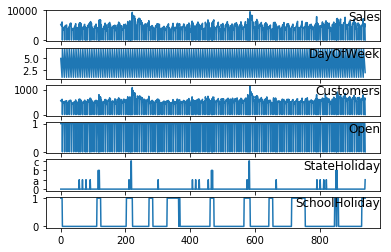

In [24]:
dataset = read_csv('rossman2.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [25]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
# load dataset
dataset = read_csv('rossman2.csv', header=0, index_col=0)
values = dataset.values
print(type(values))
# integer encode direction(categorical to numeric conversion)
encoder = LabelEncoder()

values[:, 1] = encoder.fit_transform(values[:, 1])
print("DayOfWeek",encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 3] = encoder.fit_transform(values[:, 3])
print("Open",encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 4] = encoder.fit_transform(values[:, 4])
print('Promo',encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 5] = encoder.fit_transform(values[:, 5])
print('StateHoliday',encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 6] = encoder.fit_transform(values[:, 6])
print('SchoolHoliday',encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 7] = encoder.fit_transform(values[:, 7])
print('StoreType',encoder.classes_)
print(encoder.transform(encoder.classes_))

values[:, 8] = encoder.fit_transform(values[:, 8])
print('Assortment',encoder.classes_)
print(encoder.transform(encoder.classes_))

# convert all data to float
values = values.astype('float32')
#print(values[:,1])
# normalize features
print(values.shape)
print(values)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[1,:])
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[x for x in range(14,26,1)]], axis=1, inplace=True)
#print(reframed.shape)
#print(reframed.head())

<class 'numpy.ndarray'>
DayOfWeek [1 2 3 4 5 6 7]
[0 1 2 3 4 5 6]
Open [0 1]
[0 1]
Promo [0 1]
[0 1]
StateHoliday ['0' 'a' 'b' 'c']
[0 1 2 3]
SchoolHoliday [0 1]
[0 1]
StoreType ['c']
[0]
Assortment ['a']
[0]
(942, 13)
[[5.263e+03 4.000e+00 5.550e+02 ... 9.000e+00 2.008e+03 0.000e+00]
 [5.020e+03 3.000e+00 5.460e+02 ... 9.000e+00 2.008e+03 0.000e+00]
 [4.782e+03 2.000e+00 5.230e+02 ... 9.000e+00 2.008e+03 0.000e+00]
 ...
 [4.327e+03 3.000e+00 5.780e+02 ... 9.000e+00 2.008e+03 0.000e+00]
 [5.530e+03 2.000e+00 6.680e+02 ... 9.000e+00 2.008e+03 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 ... 9.000e+00 2.008e+03 0.000e+00]]
[0.52686816 0.5        0.48318583 1.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.        ]


In [27]:
# split into train and test sets
values = reframed.values
#print(values)
n_train_days = 110
test = values[:n_train_days, :]
train = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(831, 1, 13) (831,) (110, 1, 13) (110,)


In [28]:
# design network
'''
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True,activation='relu'))
model.add(LSTM(95,return_sequences=True,activation='relu'))
model.add(LSTM(100,return_sequences=True,activation='sigmoid'))
model.add(LSTM(40,return_sequences=True,activation='sigmoid'))
model.add(LSTM(30,return_sequences=False,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,
                    epochs=100,
                    batch_size=4,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

#model save
model.save("model6.h5")
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 
'''

'\nmodel = Sequential()\nmodel.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True,activation=\'relu\'))\nmodel.add(LSTM(95,return_sequences=True,activation=\'relu\'))\nmodel.add(LSTM(100,return_sequences=True,activation=\'sigmoid\'))\nmodel.add(LSTM(40,return_sequences=True,activation=\'sigmoid\'))\nmodel.add(LSTM(30,return_sequences=False,activation=\'relu\'))\nmodel.add(Dense(1))\nmodel.compile(loss=\'mae\', optimizer=\'adam\')\n# fit network\nhistory = model.fit(train_X, train_y,\n                    epochs=100,\n                    batch_size=4,\n                    validation_data=(test_X, test_y),\n                    verbose=2,\n                    shuffle=False)\n\n#model save\nmodel.save("model6.h5")\n# plot history\npyplot.plot(history.history[\'loss\'], label=\'train\')\npyplot.plot(history.history[\'val_loss\'], label=\'test\')\npyplot.legend()\npyplot.show() \n'

In [29]:
model = load_model('model6.h5')

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [31]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
#print(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
#print('\n',inv_yhat)
inv_yhat = inv_yhat[:, 0]

In [32]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
print(test_y.shape)
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
#print(inv_y)
#print(inv_yhat)

(110, 1)


In [33]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1067.314


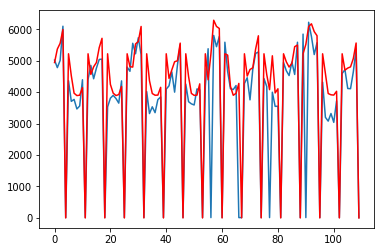

In [34]:
#forecasting
plt.plot(inv_y)
plt.plot(inv_yhat,color='red')

<function matplotlib.pyplot.show(*args, **kw)>

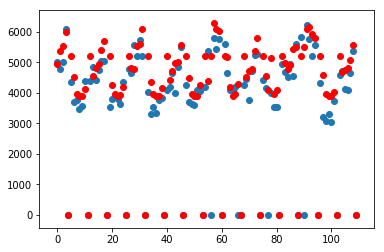

In [35]:
plt.scatter(np.array(range(len(inv_y))),inv_y)
plt.scatter(np.array(range(len(inv_yhat))),inv_yhat,c='r')
plt.show

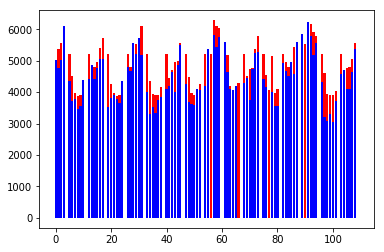

In [36]:
X=range(len(inv_y))
plt.bar(X, inv_yhat, color = 'r')
plt.bar(X, inv_y, color = 'b')
plt.show()

In [37]:
def encoding_pred(raw_ip):
    raw_ip[0][1]=raw_ip[0][1]-1
    if raw_ip[0][5]=='a':
        raw_ip[0][5]=1
    if raw_ip[0][5]=='b':
        raw_ip[0][5]=2
    if raw_ip[0][5]=='c':
        raw_ip[0][5]=3
    raw_ip[0][7],raw_ip[0][8]=0,0
    return raw_ip

In [38]:
raw_input=[[5220,5,582,1,1,0,0,'c','a',1270,9,2008,0]]
encoded_ip=encoding_pred(raw_input)
encoded_ip=np.array(encoded_ip)
print(encoded_ip)

[[5220    4  582    1    1    0    0    0    0 1270    9 2008    0]]


In [39]:
encoded_ip = encoded_ip.astype('float32')
scaled_ip = scaler.transform(encoded_ip)
print(scaled_ip)
scaled_ip=scaled_ip.reshape((1, 1, 13))
print(scaled_ip.shape)

[[0.54785895 0.6666667  0.5150443  1.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
(1, 1, 13)


In [40]:
tommorowsales = model.predict(scaled_ip)
print(tommorowsales)

[[0.53145397]]


In [41]:
print(tommorowsales.shape)

(1, 1)


In [42]:
scaled_ip=scaled_ip.reshape((1, 13))
inv_tommorowsales = concatenate((tommorowsales,scaled_ip[:, 1:]), axis=1)
inv_tommorowsales = scaler.inverse_transform(inv_tommorowsales)
inv_tommorowsales = inv_tommorowsales[:, 0]
print(inv_tommorowsales)

[5063.6934]
